In [1]:
%pip install calmap --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install plotly-calplot --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import calmap
from plotly_calplot import calplot
pd.set_option('display.max_columns', 500)
plt.style.use('seaborn-dark-palette')

C:\Users\hello\AppData\Local\Temp\ipykernel_17304\870512111.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


In [4]:
df = pd.read_excel('data_raw.xlsx')

In [5]:
#Lựa chọn những thuộc tính sử dụng
df = df[['OriginStateFips', 'DestStateFips', 'CRSDepTime', 'DepDelay', 'Cancelled']]

In [6]:
df = df.reset_index(drop=True)
df

,OriginStateFips,DestStateFips,CRSDepTime,DepDelay,Cancelled
0,6,4,1650,18.0,False
1,6,4,1650,22.0,False
2,6,4,1650,25.0,False
3,6,4,1650,-1.0,False
4,6,4,1650,-2.0,False
...,...,...,...,...,...
135635,26,17,1650,-2.0,False
135636,17,42,1850,80.0,False
135637,39,51,608,-14.0,False
135638,17,39,1036,-7.0,False


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   OriginStateFips  135640 non-null  int64  
 1   DestStateFips    135640 non-null  int64  
 2   CRSDepTime       135640 non-null  int64  
 3   DepDelay         134277 non-null  float64
 4   Cancelled        135640 non-null  bool   
dtypes: bool(1), float64(1), int64(3)
memory usage: 4.3 MB


In [8]:
#chuyển đổi giá trị trong cột 'CRSDepTime' sang kiểu dữ liệu chuỗi (string) thêm các ký tự '0' vào đầu chuỗi (nếu cần) để đảm bảo rằng chiều dài của chuỗi là 4 ký tự
df['CRSDepTime'] = df['CRSDepTime'].astype(str).str.zfill(4)

In [9]:

# Phân loại giá trị CRSDepTime thành các khoảng
df.loc[df['CRSDepTime'].astype(str).str[:2].astype(int) <= 6, 'CRSDepTime'] = 1  # Early Morning
df.loc[(df['CRSDepTime'].astype(str).str[:2].astype(int) > 6) & (df['CRSDepTime'].astype(str).str[:2].astype(int) <= 12), 'CRSDepTime'] = 2  # Morning
df.loc[(df['CRSDepTime'].astype(str).str[:2].astype(int) > 12) & (df['CRSDepTime'].astype(str).str[:2].astype(int) <= 18), 'CRSDepTime'] = 3  # Afternoon
df.loc[df['CRSDepTime'].astype(str).str[:2].astype(int) > 18, 'CRSDepTime'] = 4  # Evening

# Chuyển đổi kiểu dữ liệu của cột 'CRSDepTime' thành 'int64'
df['CRSDepTime'] = df['CRSDepTime'].astype('int64')

unique_CRSDepTime = df['CRSDepTime'].unique()

print("Các giá trị khác nhau của cột 'CRSDepTime':", unique_CRSDepTime)

Các giá trị khác nhau của cột 'CRSDepTime': [3 2 1 4]


In [10]:
#Tạo cột DelayGroup để phân loại tình trạng chuyến bay
df['DelayGroup'] = None
df.loc[df['DepDelay'] <= 0, 'DelayGroup'] = 'OnTime_Early' 
df.loc[(df['DepDelay'] > 0), 'DelayGroup'] = 'Delay'
df.loc[df['Cancelled'], 'DelayGroup'] = 'Cancelled'
df

,OriginStateFips,DestStateFips,CRSDepTime,DepDelay,Cancelled,DelayGroup
0,6,4,3,18.0,False,Delay
1,6,4,3,22.0,False,Delay
2,6,4,3,25.0,False,Delay
3,6,4,3,-1.0,False,OnTime_Early
4,6,4,3,-2.0,False,OnTime_Early
...,...,...,...,...,...,...
135635,26,17,3,-2.0,False,OnTime_Early
135636,17,42,3,80.0,False,Delay
135637,39,51,1,-14.0,False,OnTime_Early
135638,17,39,2,-7.0,False,OnTime_Early


In [11]:
#Tính toán và in ra tỷ lệ phần trăm chuyến bay bị hủy so với tổng số chuyến bay
print(df['Cancelled'].value_counts())
print('Percent Cancelled :', round(sum(df['Cancelled'] == True) / len(df['Cancelled']) * 100, 2), '% of all flights')

False    134244
True       1396
Name: Cancelled, dtype: int64
Percent Cancelled : 1.03 % of all flights


In [12]:
#Đếm số lượng chuyến bay trong mỗi nhóm thời gian
print('Số lượng')
print(df['DelayGroup'].value_counts())
print('====')
print((df['DelayGroup'].value_counts() / df.shape[0] * 100).round(2))
print(sum(df['DelayGroup'].value_counts() / df.shape[0] * 100))

Số lượng
OnTime_Early    87616
Delay           46628
Cancelled        1396
Name: DelayGroup, dtype: int64
====
OnTime_Early    64.59
Delay           34.38
Cancelled        1.03
Name: DelayGroup, dtype: float64
100.0


In [13]:
# Lấy top 3 giá trị của cột 'OriginStateFips'
top_origin = df['OriginStateFips'].value_counts().nlargest(3).index.tolist()

# Lấy top 3 giá trị của cột 'DestStateFips'
top_dest = df['DestStateFips'].value_counts().nlargest(3).index.tolist()

# Chỉ giữ lại các hàng có giá trị trong top 3 của cả hai cột
df = df[df['OriginStateFips'].isin(top_origin) & df['DestStateFips'].isin(top_dest)]

**Decision Tree**

In [14]:
dt =df.drop(['DepDelay', 'Cancelled'], axis=1)

In [15]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14257 entries, 13 to 135420
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   OriginStateFips  14257 non-null  int64 
 1   DestStateFips    14257 non-null  int64 
 2   CRSDepTime       14257 non-null  int64 
 3   DelayGroup       14257 non-null  object
dtypes: int64(3), object(1)
memory usage: 556.9+ KB


In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [17]:
#Tách các cột dữ liệu vào 2 biến features (chứa các thuộc tính bình thường) và biến labels (chứa riêng thuộc tính quyết định)
features = dt.drop('DelayGroup', axis=1)
labels = dt['DelayGroup']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [19]:
from sklearn import tree
# Xây dựng cây ID3
clf = tree.DecisionTreeClassifier(criterion="entropy", random_state=0)

# Huấn luyện mô hình
clf.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', random_state=0)

In [20]:
#Predict the response for test dataset
tree_pred = clf.predict(X_test)
#Model Accuracy, how often is the classifier corect?
from sklearn import metrics
tree_score = metrics.accuracy_score(y_test, tree_pred)
print("Accuracy: ", tree_score)
print("Report: ", metrics.classification_report(y_test, tree_pred))

Accuracy:  0.6346423562412342
Report:                precision    recall  f1-score   support

   Cancelled       0.00      0.00      0.00        40
       Delay       0.57      0.26      0.36      1081
OnTime_Early       0.65      0.88      0.75      1731

    accuracy                           0.63      2852
   macro avg       0.41      0.38      0.37      2852
weighted avg       0.61      0.63      0.59      2852



c:\Users\hello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [21]:
#Tính toán ma trận nhầm lẫn
tree_cm = metrics.confusion_matrix(y_test, tree_pred)

Text(0.5, 1.0, 'Decision Tree Accuracy Score: 0.6346423562412342')

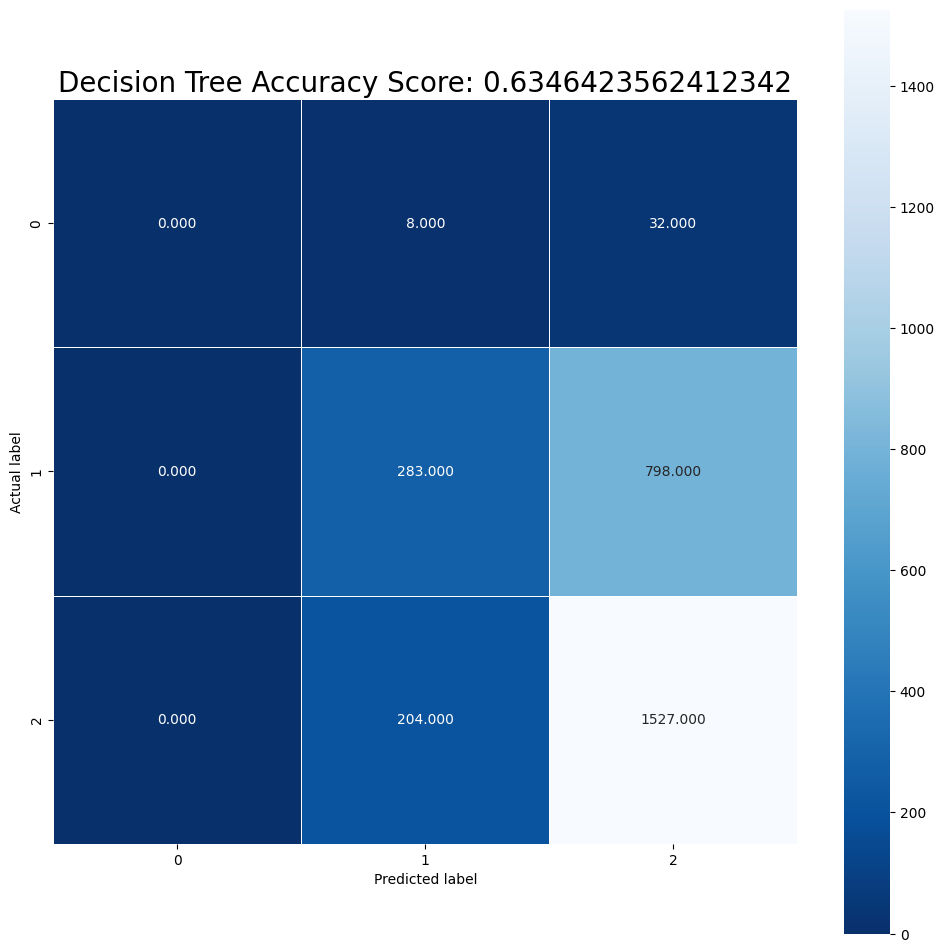

In [22]:
#Biểu diễn lên đồ thị hearmap
plt.figure(figsize=(12,12))
sns.heatmap(tree_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
title = 'Decision Tree Accuracy Score: {0}'.format(tree_score)
plt.title(title, size = 20)

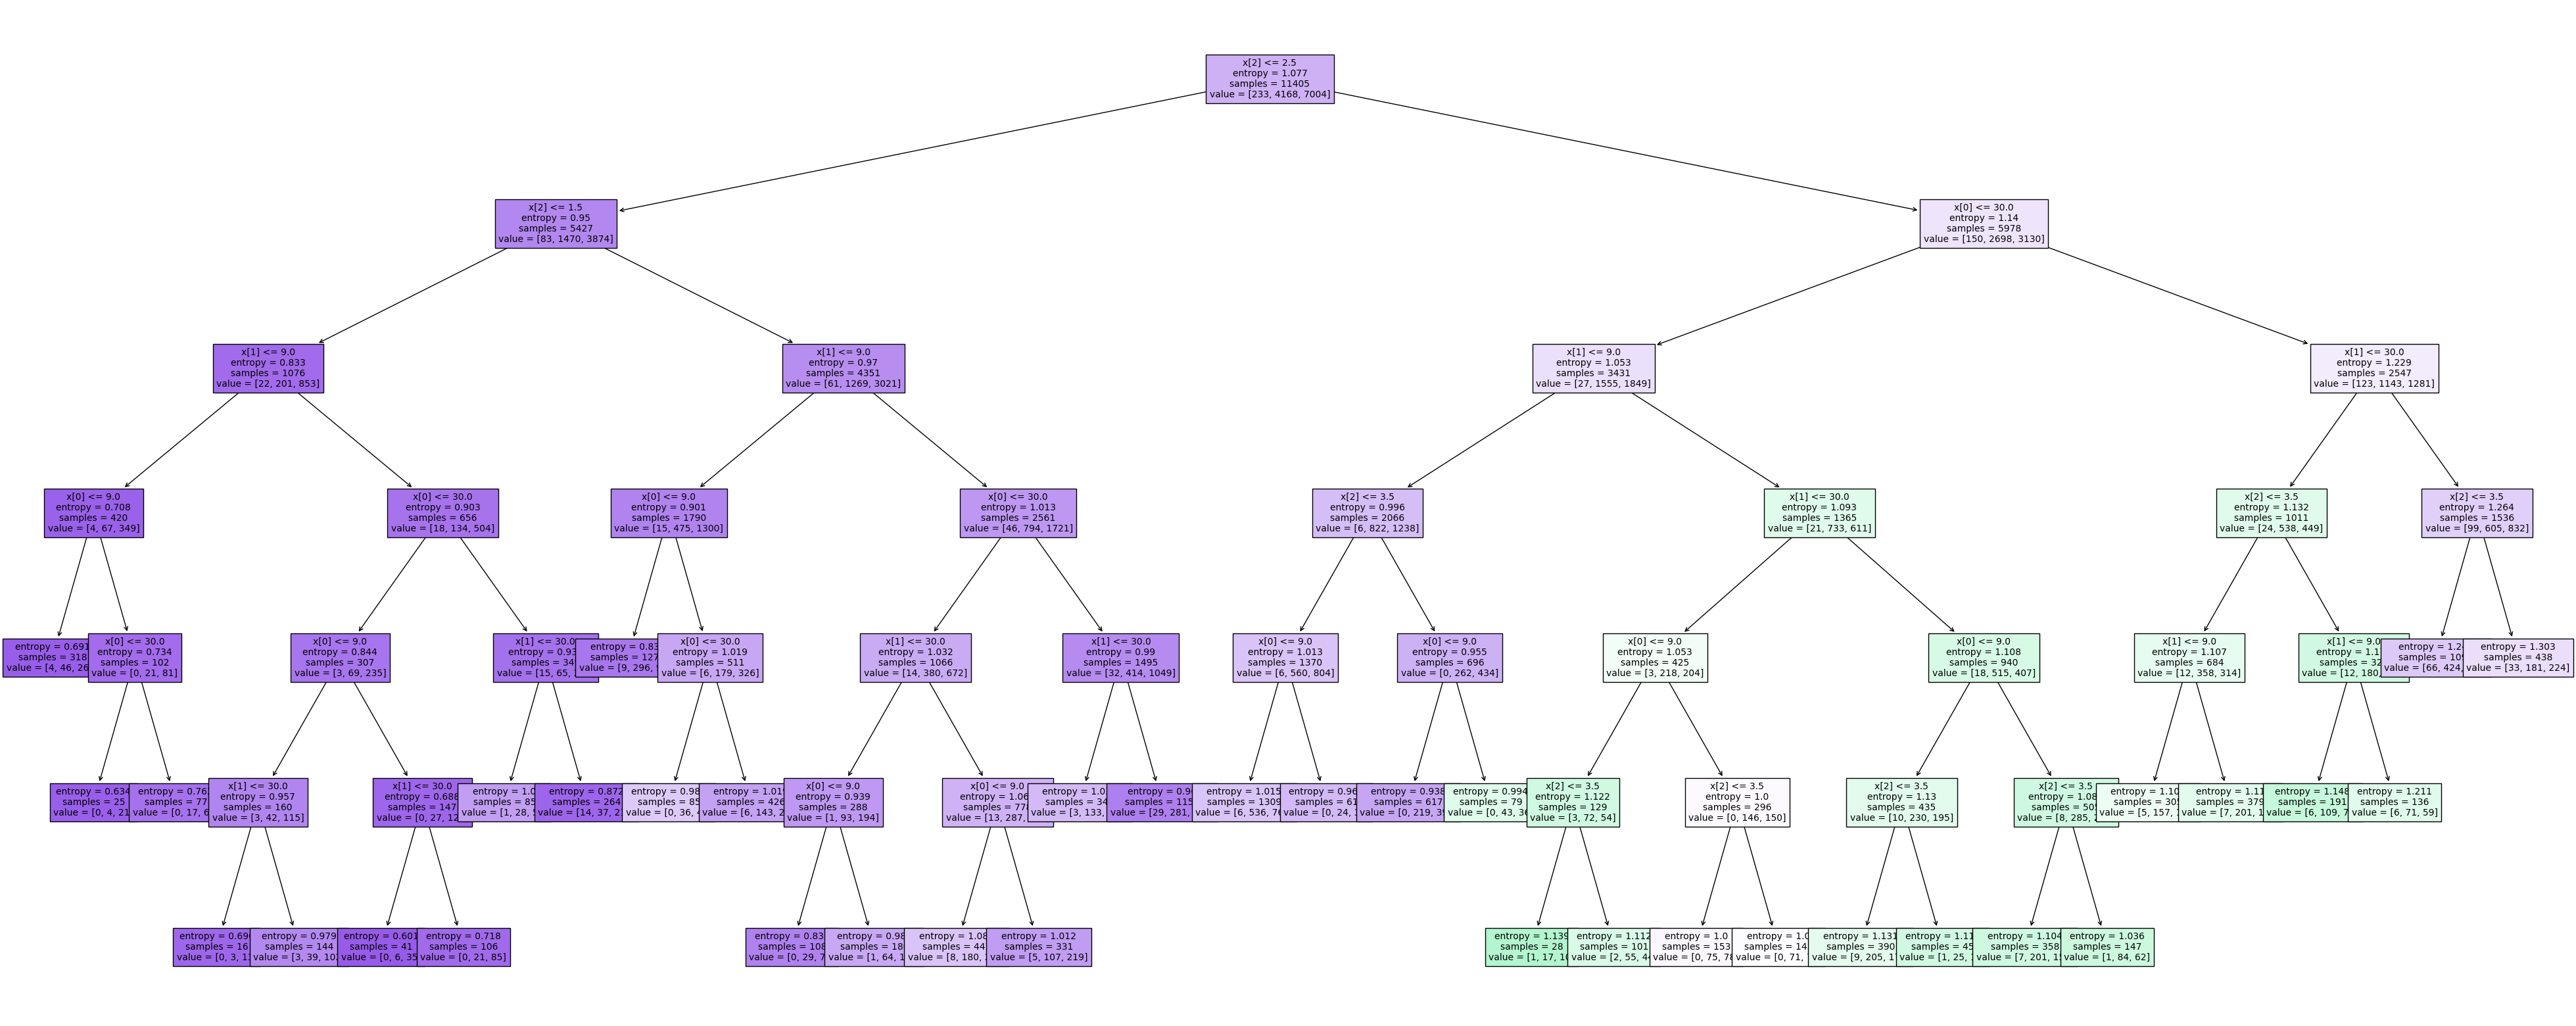

In [23]:
#biểu diễn cây ID3
fig, ax = plt.subplots(figsize=(50,20))
tree.plot_tree(clf, filled=True, fontsize=10)
plt.savefig('decision_tree', dpi=100)
plt.show()
#Câu lệnh savefig với dpi=100 giúp lưu lại cây vào file ‘decision_tree.png’ với chất lượng tốt.

In [24]:
from sklearn.tree import export_text
feature_names = ["CRSDepTime", "OriginStateFips", "DestStateFips"]
rules = export_text(clf, feature_names=feature_names)
print(rules)


|--- DestStateFips <= 2.50
|   |--- DestStateFips <= 1.50
|   |   |--- OriginStateFips <= 9.00
|   |   |   |--- CRSDepTime <= 9.00
|   |   |   |   |--- class: OnTime_Early
|   |   |   |--- CRSDepTime >  9.00
|   |   |   |   |--- CRSDepTime <= 30.00
|   |   |   |   |   |--- class: OnTime_Early
|   |   |   |   |--- CRSDepTime >  30.00
|   |   |   |   |   |--- class: OnTime_Early
|   |   |--- OriginStateFips >  9.00
|   |   |   |--- CRSDepTime <= 30.00
|   |   |   |   |--- CRSDepTime <= 9.00
|   |   |   |   |   |--- OriginStateFips <= 30.00
|   |   |   |   |   |   |--- class: OnTime_Early
|   |   |   |   |   |--- OriginStateFips >  30.00
|   |   |   |   |   |   |--- class: OnTime_Early
|   |   |   |   |--- CRSDepTime >  9.00
|   |   |   |   |   |--- OriginStateFips <= 30.00
|   |   |   |   |   |   |--- class: OnTime_Early
|   |   |   |   |   |--- OriginStateFips >  30.00
|   |   |   |   |   |   |--- class: OnTime_Early
|   |   |   |--- CRSDepTime >  30.00
|   |   |   |   |--- OriginStateF

In [25]:
dt['DestStateFips'].unique()

array([48,  6, 12], dtype=int64)

In [26]:
#Dự đoán tình trạng chuyến bay (labels) dựa trên các giá trị thuộc tính (features)
#OriginStateFips	DestStateFips	CRSDepTime		-> DelayGroup
new_data = {
    'CRSDepTime': '2120',                           #Thời gian khởi hành theo máy tính: 21:20
    'OriginStateFips': 12,                          #Fort Myers, Florida
    'DestStateFips': 48                             #Newark, New Jersey
}

In [27]:
# Chuyển đổi dữ liệu đầu vào thành DataFrame để có thể áp dụng mô hình dự đoán
new_data_dt = pd.DataFrame([new_data])
new_data_dt

,CRSDepTime,OriginStateFips,DestStateFips
0,2120,12,48


In [28]:
#chuyển đổi giá trị trong cột 'CRSDepTime' sang kiểu dữ liệu chuỗi (string) thêm các ký tự '0' vào đầu chuỗi (nếu cần) để đảm bảo rằng chiều dài của chuỗi là 4 ký tự
new_data_dt['CRSDepTime'] = new_data_dt['CRSDepTime'].astype(str).str.zfill(4)


# Phân loại giá trị CRSDepTime thành các khoảng
new_data_dt.loc[new_data_dt['CRSDepTime'].astype(str).str[:2].astype(int) <= 6, 'CRSDepTime'] = 1  # Early Morning
new_data_dt.loc[(new_data_dt['CRSDepTime'].astype(str).str[:2].astype(int) > 6) & (df['CRSDepTime'].astype(str).str[:2].astype(int) <= 12), 'CRSDepTime'] = 2  # Morning
new_data_dt.loc[(new_data_dt['CRSDepTime'].astype(str).str[:2].astype(int) > 12) & (df['CRSDepTime'].astype(str).str[:2].astype(int) <= 18), 'CRSDepTime'] = 3  # Afternoon
new_data_dt.loc[new_data_dt['CRSDepTime'].astype(str).str[:2].astype(int) > 18, 'CRSDepTime'] = 4  # Evening

# Chuyển đổi kiểu dữ liệu của cột 'CRSDepTime' thành 'int64'
new_data_dt['CRSDepTime'] = new_data_dt['CRSDepTime'].astype('int64')

In [29]:
# Lấy danh sách tên cột của quá trình huấn luyện
train_columns = X_train.columns.tolist()

# Sắp xếp lại thứ tự cột trong new_data_encoded
new_data_dt = new_data_dt.reindex(columns=train_columns)

# Dự đoán labels cho dữ liệu mới đã được mã hóa
predicted_labels = clf.predict(new_data_dt)

# In ra nhãn dự đoán
print(predicted_labels)

['Delay']


**Thuật toán Random Forest**

In [30]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder


In [31]:
rf = df.drop(['DepDelay', 'Cancelled'], axis=1)
rf

,OriginStateFips,DestStateFips,CRSDepTime,DelayGroup
13,6,48,3,Delay
14,6,6,1,OnTime_Early
15,6,6,3,Delay
16,6,6,2,OnTime_Early
17,6,6,2,Delay
...,...,...,...,...
135386,48,48,2,OnTime_Early
135388,48,48,3,OnTime_Early
135392,12,48,2,OnTime_Early
135401,48,48,3,Delay


In [32]:
rf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14257 entries, 13 to 135420
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   OriginStateFips  14257 non-null  int64 
 1   DestStateFips    14257 non-null  int64 
 2   CRSDepTime       14257 non-null  int64 
 3   DelayGroup       14257 non-null  object
dtypes: int64(3), object(1)
memory usage: 1.0+ MB


In [33]:
# Chia thành input features (X) và target variable (y)
X = rf.drop('DelayGroup', axis=1)
y = rf['DelayGroup']


In [34]:
# Chia tập dữ liệu thành training set và test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Xây dựng mô hình Random Forest
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Huấn luyện mô hình trên tập huấn luyện
model.fit(X_train, y_train)

# Dự đoán tình trạng chuyến bay trên tập kiểm tra
y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score

# Đánh giá độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6388499298737728


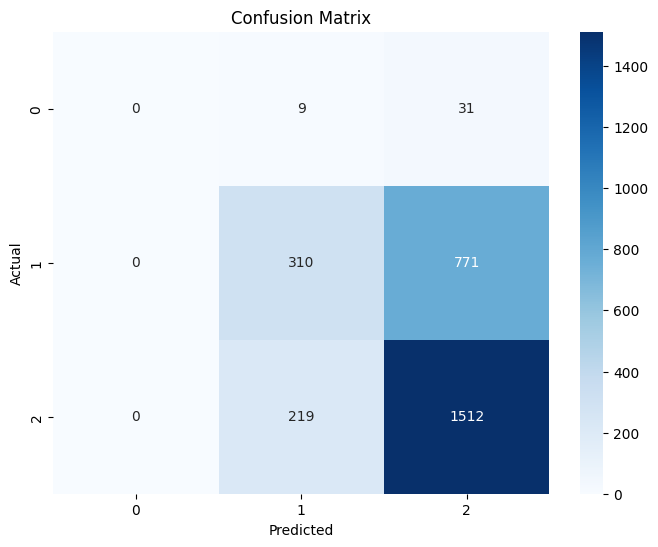

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Tính toán ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Vẽ biểu đồ ma trận confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


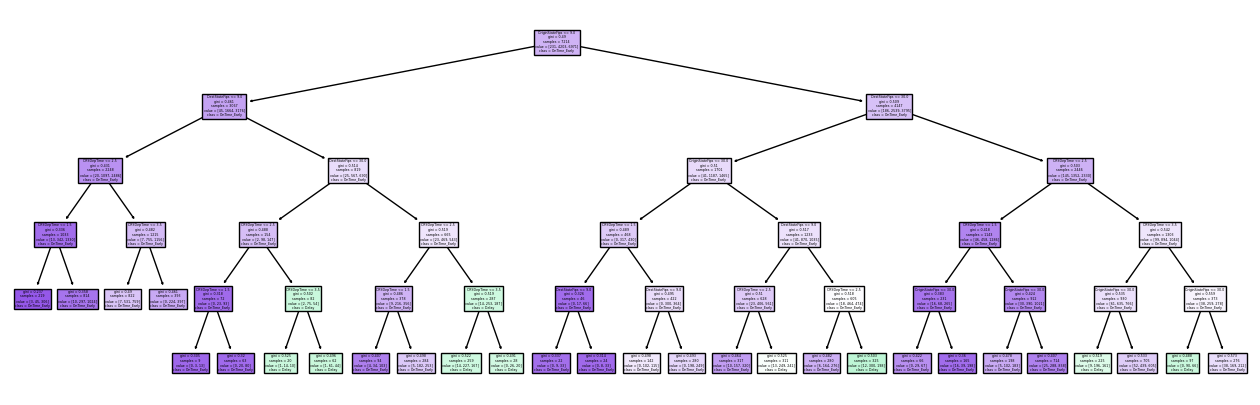

In [37]:
# Biểu diễn cây quyết định từ mô hình Random Forest với cây đầu tiên
tree_idx = 0  # Chọn cây đầu tiên (có thể thay đổi giá trị để chọn cây khác)
estimator = model.estimators_[tree_idx]

# Lấy tên các thuộc tính đầu vào
feature_names = X_train.columns.tolist()

# Vẽ biểu đồ cây quyết định
plt.figure(figsize=(16, 5))
tree.plot_tree(estimator, feature_names=feature_names, class_names=model.classes_, filled=True)
plt.savefig('rf_tree.png', dpi=300)
plt.show()

In [38]:
# #Biểu diễn cây quyết định từ mô hình Random Forest cho toàn cây
# from sklearn import tree
# # Lấy tên các thuộc tính đầu vào
# feature_names = X_train.columns.tolist()

# # Tính toán số hàng và số cột cho bố trí của biểu đồ cây
# num_trees = len(model.estimators_)
# rows = int(num_trees / 3) + 1 if num_trees % 3 != 0 else int(num_trees / 3)
# cols = 3

# # Vẽ biểu đồ cây quyết định cho toàn bộ Random Forest
# plt.figure(figsize=(50, 24))
# for i, estimator in enumerate(model.estimators_):
#     plt.subplot(rows, cols, i + 1)
#     plt.title(f"Tree {i+1}")
#     tree.plot_tree(estimator, feature_names=feature_names, class_names=model.classes_, filled=True)
# plt.tight_layout()
# plt.savefig('randomforest_tree.png', dpi=300)
# plt.show()


In [39]:
from sklearn.tree import export_text

# Lấy cây quyết định từ mô hình Random Forest
tree = model.estimators_[0]  # Lấy cây quyết định từ cây đầu tiên

# Rút ra các tập luật từ cây quyết định
rules = export_text(tree, feature_names=feature_names)

# In các tập luật
print("Tập luật từ cây quyết định:")
print(rules)


Tập luật từ cây quyết định:
|--- OriginStateFips <= 9.00
|   |--- DestStateFips <= 9.00
|   |   |--- CRSDepTime <= 2.50
|   |   |   |--- CRSDepTime <= 1.50
|   |   |   |   |--- class: 2.0
|   |   |   |--- CRSDepTime >  1.50
|   |   |   |   |--- class: 2.0
|   |   |--- CRSDepTime >  2.50
|   |   |   |--- CRSDepTime <= 3.50
|   |   |   |   |--- class: 2.0
|   |   |   |--- CRSDepTime >  3.50
|   |   |   |   |--- class: 2.0
|   |--- DestStateFips >  9.00
|   |   |--- DestStateFips <= 30.00
|   |   |   |--- CRSDepTime <= 2.50
|   |   |   |   |--- CRSDepTime <= 1.50
|   |   |   |   |   |--- class: 2.0
|   |   |   |   |--- CRSDepTime >  1.50
|   |   |   |   |   |--- class: 2.0
|   |   |   |--- CRSDepTime >  2.50
|   |   |   |   |--- CRSDepTime <= 3.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- CRSDepTime >  3.50
|   |   |   |   |   |--- class: 1.0
|   |   |--- DestStateFips >  30.00
|   |   |   |--- CRSDepTime <= 2.50
|   |   |   |   |--- CRSDepTime <= 1.50
|   |   |   |   |   |

In [40]:
#Dự đoán tình trạng chuyến bay (labels) dựa trên các giá trị thuộc tính (features)
#OriginStateFips	DestStateFips	CRSDepTime		-> DelayGroup
new_data = {
    'CRSDepTime': '2120',                           #Thời gian khởi hành theo máy tính: 21:20
    'OriginStateFips': 12,                          #Fort Myers, Florida
    'DestStateFips': 48                             #Newark, New Jersey
}

In [41]:
# Chuyển đổi dữ liệu đầu vào thành DataFrame để có thể áp dụng mô hình dự đoán
new_data_rf = pd.DataFrame([new_data])
new_data_rf

,CRSDepTime,OriginStateFips,DestStateFips
0,2120,12,48


In [42]:
new_data_rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CRSDepTime       1 non-null      object
 1   OriginStateFips  1 non-null      int64 
 2   DestStateFips    1 non-null      int64 
dtypes: int64(2), object(1)
memory usage: 156.0+ bytes


In [43]:
#chuyển đổi giá trị trong cột 'CRSDepTime' sang kiểu dữ liệu chuỗi (string) thêm các ký tự '0' vào đầu chuỗi (nếu cần) để đảm bảo rằng chiều dài của chuỗi là 4 ký tự
new_data_rf['CRSDepTime'] = new_data_rf['CRSDepTime'].astype(str).str.zfill(4)


# Phân loại giá trị CRSDepTime thành các khoảng
new_data_rf.loc[new_data_rf['CRSDepTime'].astype(str).str[:2].astype(int) <= 6, 'CRSDepTime'] = 1  # Early Morning
new_data_rf.loc[(new_data_rf['CRSDepTime'].astype(str).str[:2].astype(int) > 6) & (df['CRSDepTime'].astype(str).str[:2].astype(int) <= 12), 'CRSDepTime'] = 2  # Morning
new_data_rf.loc[(new_data_rf['CRSDepTime'].astype(str).str[:2].astype(int) > 12) & (df['CRSDepTime'].astype(str).str[:2].astype(int) <= 18), 'CRSDepTime'] = 3  # Afternoon
new_data_rf.loc[new_data_rf['CRSDepTime'].astype(str).str[:2].astype(int) > 18, 'CRSDepTime'] = 4  # Evening

# Chuyển đổi kiểu dữ liệu của cột 'CRSDepTime' thành 'int64'
new_data_rf['CRSDepTime'] = new_data_rf['CRSDepTime'].astype('int64')

In [44]:
# Lấy danh sách tên cột của quá trình huấn luyện
train_columns = X_train.columns.tolist()

# Sắp xếp lại thứ tự cột trong new_data_rf
new_data_rf = new_data_rf.reindex(columns=train_columns)

# Dự đoán tình trạng chuyến bay
new_data_pred = model.predict(new_data_rf)

# In kết quả dự đoán
print(new_data_pred)

['Delay']
